In [1]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [2]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/keras-denoising-autoencoder/keras-denoising-autoencoder.zip
!unzip -qq keras-denoising-autoencoder.zip
%cd keras-denoising-autoencoder

--2023-08-19 00:14:13--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/keras-denoising-autoencoder/keras-denoising-autoencoder.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 3.5.79.164, 3.5.78.17, 52.218.153.73, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|3.5.79.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47441 (46K) [binary/octet-stream]
Saving to: ‘keras-denoising-autoencoder.zip’

keras-denoising-aut 100%[===================>]  46.33K  --.-KB/s    in 0.06s   

2023-08-19 00:14:13 (772 KB/s) - ‘keras-denoising-autoencoder.zip’ saved [47441/47441]

/content/keras-denoising-autoencoder


In [3]:
def plt_imshow(title, image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.title(title)
  plt.grid(False)
  plt.show()

In [4]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [5]:
args = {
    "sample": 8,
    "output": "output.png",
    "plot": "plot.png"
}

In [6]:
epochs = 25
bs = 32

((trainX, _), (testX, _)) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [9]:
trainNoise = np.random.normal(loc=0.5, scale=0.5, size = trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size = testX.shape)

trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

In [10]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=epochs,
	batch_size=bs)

Epoch 1/25
1875/1875 [==============================] - 29s 7ms/step - loss: 0.0283 - val_loss: 0.0197
Epoch 2/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0188 - val_loss: 0.0188
Epoch 3/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 4/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0172 - val_loss: 0.0172
Epoch 5/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0168 - val_loss: 0.0190
Epoch 6/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0164 - val_loss: 0.0178
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 8/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0160 - val_loss: 0.0171
Epoch 9/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0158 - val_loss: 0.0160
Epoch 10/25
1875/1875 [==============================] - 12s 6ms/step - l

In [ ]:
N = np.arange(0, epochs)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label = "val_loss")

plt.title("Training loss and accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

313/313 [==============================] - 1s 3ms/step


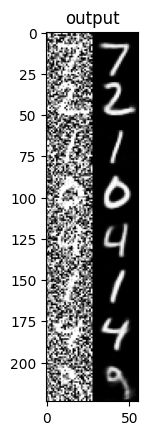

In [11]:
decoded = autoencoder.predict(testXNoisy)
outputs = None
for i in range(0, args["sample"]):
  original = (testXNoisy[i] * 255).astype("uint8")
  recon = (decoded[i] * 255).astype("uint8")

  output = np.hstack([original, recon])

  if outputs is None:
    outputs = output

  else:
    outputs = np.vstack([outputs, output])

cv2.imwrite(args["output"], outputs)
plt_imshow("output", outputs)